# Start-up

In this notebook, we provide an overview of publication medatata and create the data frames for further analyses.

In [87]:
%matplotlib inline
import matplotlib.pyplot as plt

# magics and warnings
%load_ext autoreload
%autoreload 2
import warnings; warnings.simplefilter('ignore')

import os, random, codecs, json
import pandas as pd
import numpy as np

seed = 99
random.seed(seed)
np.random.seed(seed)

import nltk, sklearn
import matplotlib.pyplot as plt
from  matplotlib.ticker import FuncFormatter
import seaborn as sns
sns.set(style="white")
sns.set_context("paper", font_scale=1.2, rc={"lines.linewidth": 2.5})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# load publication metadata

df_meta = pd.read_csv("../cwts_covid/datasets_output/df_pub.csv",compression="gzip")

In [3]:
df_meta.head()

,pub_id,title,abstract,publication_year,publication_month,journal,volume,issue,pages,doi,pmid,pmcid,dimensions_id,timestamp
0,0,‘A ticking time bomb’: Scientists worry about ...,"CAPE TOWN, SOUTH AFRICA—Late on Sunday evening...",2020.0,NaN,Science,NaN,NaN,NaN,0.1126/science.abb7331,NaN,NaN,NaN,2020-04-25 09:08:51.611715
1,1,[Ten hot issues of breast cancer under the nov...,NaN,2020.0,2.0,Chinese medical journal,100,0,e002,10.0376/cma.j.issn.0376-2491.2020.0002,32036640.0,NaN,pub.1124777091,2020-04-25 09:08:51.611715
2,2,Another Piece of the Puzzle: Human Metapneumov...,BACKGROUND: Each winter respiratory viruses ac...,2008.0,12.0,Archives of Internal Medicine,NaN,NaN,NaN,10.1001/archinte.168.22.2489,19064834.0,pmc2783624,NaN,2020-04-25 09:08:51.611715
3,3,Viral etiology of severe pneumonia among Kenya...,CONTEXT: Pneumonia is the leading cause of chi...,2010.0,5.0,JAMA,NaN,NaN,NaN,10.1001/jama.2010.675,20501927.0,pmc2968755,NaN,2020-04-25 09:08:51.611715
4,4,Critically Ill Patients With Influenza A(H1N1)...,NaN,2014.0,4.0,JAMA,NaN,NaN,NaN,10.1001/jama.2014.2116,24566924.0,pmc6689404,NaN,2020-04-25 09:08:51.611715


In [4]:
df_meta.columns

Index(['pub_id', 'title', 'abstract', 'publication_year', 'publication_month',
       'journal', 'volume', 'issue', 'pages', 'doi', 'pmid', 'pmcid',
       'dimensions_id', 'timestamp'],
      dtype='object')

In [341]:
df_meta.shape

(69969, 15)

#### Publication years

In [6]:
import re

def clean_year(s):
    if pd.isna(s):
        return np.nan
    if not (s>1900):
        return np.nan
    elif s>2020:
        return 2020
    return s

df_meta["publication_year"] = df_meta["publication_year"].apply(clean_year)

In [7]:
df_meta.publication_year.describe()

count    69951.000000
mean      2012.849266
std          8.605079
min       1951.000000
25%       2009.000000
50%       2016.000000
75%       2020.000000
max       2020.000000
Name: publication_year, dtype: float64

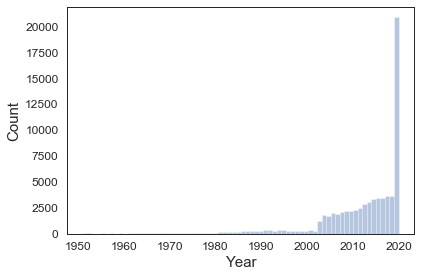

In [74]:
b = sns.distplot(df_meta.publication_year, bins=70, kde=False)
b.set_xlabel("Year",fontsize=15)
b.set_ylabel("Count",fontsize=15)
b.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig("figures/meta_pub_year_all.pdf")

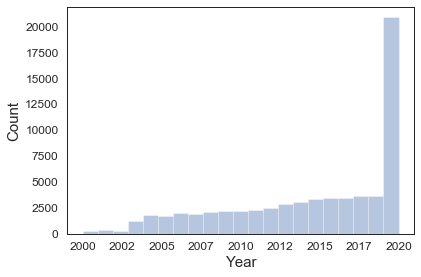

In [413]:
b = sns.distplot([int(y) for y in df_meta[df_meta.publication_year>1999].publication_year.tolist() if y], bins=21, kde=False)
b.set_xlabel("Year",fontsize=15)
b.set_ylabel("Count",fontsize=15)
b.tick_params(labelsize=12)
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
plt.tight_layout()
plt.savefig("figures/meta_pub_year_2000.pdf")

#### Detect language

In [208]:
from langdetect import detect
from langdetect import DetectorFactory
DetectorFactory.seed = seed

In [209]:
df_meta["title"] = df_meta["title"].fillna('')
df_meta["abstract"] = df_meta["abstract"].fillna('')
df_meta["title_abstract"] = df_meta.title +" "+df_meta.abstract

In [210]:
df_meta["lang"] = None

In [211]:
def detect_lang(txt):
    try:
        return detect(txt)
    except:
        return None

In [212]:
%%time

df_meta["lang"] = df_meta["title_abstract"].apply(detect_lang)

CPU times: user 13min 25s, sys: 17.5 s, total: 13min 43s
Wall time: 15min 17s


In [214]:
df_meta.drop(columns="title_abstract", inplace=True)

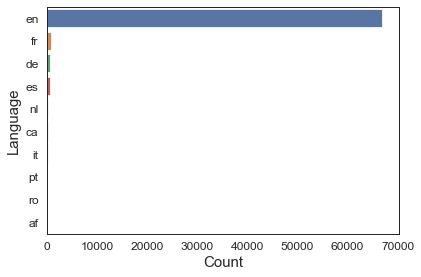

In [213]:
# languages

df_sub = df_meta[df_meta.lang.isin(df_meta.lang.value_counts()[:10].index.tolist())]
b = sns.countplot(y="lang", data=df_sub, order=df_sub['lang'].value_counts().index)
#b.axes.set_title("Title",fontsize=50)
b.set_xlabel("Count",fontsize=15)
b.set_ylabel("Language",fontsize=15)
b.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig("figures/meta_lang.pdf")

## Dimensions

In [8]:
# load Dimensions data (you will need to download it on your own)

directory_name = "../cwts_covid/datasets_output/json_dimensions_cwts"

all_dimensions = list()
for root, dirs, files in os.walk(directory_name):
    for file in files:
        if ".json" in file:
            all_data = codecs.open(os.path.join(root,file)).read()
            for record in all_data.split("\n"):
                if record:
                    all_dimensions.append(json.loads(record))

In [9]:
#all_dimensions[0]

In [13]:
df_dimensions = pd.DataFrame.from_dict({
    "id":[r["id"] for r in all_dimensions],
    "altmetric_id":[r["altmetric_id"] for r in all_dimensions],
    "year":[r["year"] for r in all_dimensions],
    "month":[int(r["publication_date"][5:7]) for r in all_dimensions],
    "publication_date":[r["publication_date"] for r in all_dimensions],
    "publication_type":[r["publication_type"] for r in all_dimensions],
    "doi":[r["doi"] for r in all_dimensions],
    "pmid":[r["pmid"] for r in all_dimensions],
    "issn":[r["journal"]["issn"] for r in all_dimensions],
    "times_cited":[r["times_cited"] for r in all_dimensions],
    "relative_citation_ratio":[r["relative_citation_ratio"] for r in all_dimensions],
    "for_top":[r["for"][0]["first_level"]["name"] if len(r["for"])>0 else "" for r in all_dimensions],
    "for_bottom":[r["for"][0]["second_level"]["name"] if len(r["for"])>0 else "" for r in all_dimensions]
})

In [14]:
df_dimensions.head()

,id,altmetric_id,year,month,publication_date,publication_type,doi,pmid,issn,times_cited,relative_citation_ratio,for_top,for_bottom
0,pub.1079036279,3199245.0,2015,6,2015-06-01,article,10.1099/vir.0.000071,25626684,0022-1317,4,0.85,Biological Sciences,Genetics
1,pub.1017501613,3907098.0,2015,5,2015-05-26,article,10.1098/rstb.2014.0107,25870393,0962-8436,122,7.58,Agricultural and Veterinary Sciences,Veterinary Sciences
2,pub.1051705324,2947902.0,2015,5,2015-05-07,article,10.1098/rspb.2015.0347,25833863,0962-8452,75,3.38,Medical and Health Sciences,Public Health and Health Services
3,pub.1030800822,3099623.0,2015,5,2015-05-01,article,10.1099/vir.0.000058,25614588,0022-1317,11,0.54,Biological Sciences,Biochemistry and Cell Biology
4,pub.1038764870,3768000.0,2015,4,2015-04-19,article,10.1098/rstb.2014.0378,25750241,0962-8436,16,0.55,Medical and Health Sciences,Clinical Sciences


In [15]:
df_dimensions.dtypes

id                          object
altmetric_id               float64
year                         int64
month                        int64
publication_date            object
publication_type            object
doi                         object
pmid                        object
issn                        object
times_cited                  int64
relative_citation_ratio    float64
for_top                     object
for_bottom                  object
dtype: object

In [33]:
# We only focus on publications with DOI or PMID since Altmetrics data is limited to those
# to check:
# df_dimensions[pd.isnull(df_dimensions.doi) & pd.isnull(df_dimensions.pmid) & pd.notnull(df_dimensions.altmetric_id)]

In [34]:
df_dimensions.pmid = df_dimensions.pmid.astype(float)

In [35]:
df_dimensions.shape

(68302, 13)

In [215]:
df_joined_doi = df_meta[pd.notnull(df_meta.doi)].merge(df_dimensions[pd.notnull(df_dimensions.doi)], how="inner", suffixes=('','_y'), left_on="doi", right_on="doi", copy=False)

In [216]:
df_joined_doi.shape

(64792, 27)

In [217]:
df_joined_pmid = df_meta[pd.isnull(df_meta.doi) & pd.notnull(df_meta.pmid)].merge(df_dimensions[pd.isnull(df_dimensions.doi) & pd.notnull(df_dimensions.pmid)], how="inner", suffixes=('','_y'), left_on="pmid", right_on="pmid", copy=False)

In [218]:
df_joined_pmid.shape

(1113, 27)

In [219]:
df_joined = pd.concat([df_joined_doi,df_joined_pmid])
df_joined = df_joined[df_joined.columns.drop(["doi_y","pmid_y"])]

In [220]:
df_joined.head()

,pub_id,title,abstract,publication_year,publication_month,journal,volume,issue,pages,doi,...,altmetric_id,year,month,publication_date,publication_type,issn,times_cited,relative_citation_ratio,for_top,for_bottom
0,1,[Ten hot issues of breast cancer under the nov...,,2020.0,2.0,Chinese medical journal,100,0,e002,10.0376/cma.j.issn.0376-2491.2020.0002,...,75778970.0,2020,2,2020-02-10,article,0376-2491,0,NaN,,
1,2,Another Piece of the Puzzle: Human Metapneumov...,BACKGROUND: Each winter respiratory viruses ac...,2008.0,12.0,Archives of Internal Medicine,NaN,NaN,NaN,10.1001/archinte.168.22.2489,...,25473830.0,2008,12,2008-12-08,article,2168-6106,122,3.11,Medical and Health Sciences,Medical Microbiology
2,3,Viral etiology of severe pneumonia among Kenya...,CONTEXT: Pneumonia is the leading cause of chi...,2010.0,5.0,JAMA,NaN,NaN,NaN,10.1001/jama.2010.675,...,4326145.0,2010,5,2010-05-26,article,0098-7484,209,8.35,Medical and Health Sciences,Medical Microbiology
3,4,Critically Ill Patients With Influenza A(H1N1)...,,2014.0,4.0,JAMA,NaN,NaN,NaN,10.1001/jama.2014.2116,...,2141513.0,2014,4,2014-04-02,article,0098-7484,17,0.76,,
4,5,"Prevalence of Depression, Depressive Symptoms,...",IMPORTANCE: Medical students are at high risk ...,2016.0,12.0,JAMA,NaN,NaN,NaN,10.1001/jama.2016.17324,...,14514980.0,2016,12,2016-12-06,article,0098-7484,346,37.44,Medical and Health Sciences,Public Health and Health Services


In [221]:
df_joined.shape

(65905, 26)

In [222]:
df_joined = df_joined.groupby("pub_id").first().reset_index()

In [223]:
df_joined[df_joined.pub_id==29534]

,pub_id,title,abstract,publication_year,publication_month,journal,volume,issue,pages,doi,...,altmetric_id,year,month,publication_date,publication_type,issn,times_cited,relative_citation_ratio,for_top,for_bottom
28798,29534,Immune Response in the Brain: Glial Response a...,Abstract Although the brain has been considere...,2008.0,12.0,NeuroImmune Biology,NaN,NaN,NaN,10.1016/s1567-7443(07)10014-4,...,NaN,2008,1,2008-01-01,chapter,None,5,NaN,Medical and Health Sciences,Immunology


In [224]:
# Most publications are in Dimensions via DOI or PMID: we focus on these

In [225]:
df_joined.shape

(64040, 26)

In [226]:
df_meta.shape

(69969, 15)

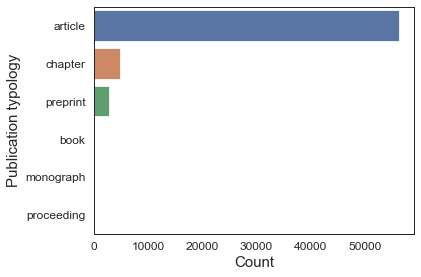

In [227]:
# publication typology

df_sub = df_joined[df_joined.publication_type.isin(df_joined.publication_type.value_counts()[:10].index.tolist())]
b = sns.countplot(y="publication_type", data=df_sub, order=df_sub['publication_type'].value_counts().index)
#b.axes.set_title("Title",fontsize=50)
b.set_xlabel("Count",fontsize=15)
b.set_ylabel("Publication typology",fontsize=15)
b.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig("figures/dim_pub_type.pdf")

#### Citation counts

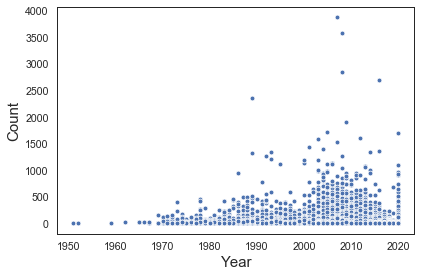

In [90]:
# scatter of citations vs time of publication

sns.scatterplot(df_joined.publication_year.to_list(),df_joined.times_cited.to_list())
plt.xlabel("Year", fontsize=15)
plt.ylabel("Count", fontsize=15)
b.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig("figures/dim_citations_year.pdf")

In [69]:
# most cited papers

df_joined[["title","times_cited","relative_citation_ratio","journal","publication_year","doi"]].sort_values("times_cited",ascending=False).head(10)

,title,times_cited,relative_citation_ratio,journal,publication_year,doi
33907,Infectious Diseases Society of America/America...,3884,108.91,Clin Infect Dis,2007.0,10.1086/511159
26001,Epidemiology and causes of preterm birth,3581,118.32,The Lancet,2008.0,10.1016/s0140-6736(08)60074-4
30448,Global trends in emerging infectious diseases,2847,70.32,Nature,2008.0,10.1038/nature06536
33470,Guidelines for the use and interpretation of a...,2699,207.35,Autophagy,2016.0,10.1080/15548627.2015.1100356
25579,Biology of Natural Killer Cells,2362,47.85,Advances in Immunology,1989.0,10.1016/s0065-2776(08)60664-1
30733,Knocking down barriers: advances in siRNA deli...,1910,47.46,Nat Rev Drug Discov,2009.0,10.1038/nrd2742
16750,Antimicrobial activity of flavonoids,1712,35.02,International Journal of Antimicrobial Agents,2005.0,10.1016/j.ijantimicag.2005.09.002
26231,Clinical features of patients infected with 20...,1706,NaN,The Lancet,2020.0,10.1016/s0140-6736(20)30183-5
32441,Isolation of a novel coronavirus from a man wi...,1604,56.64,N Engl J Med,2012.0,10.1056/nejmoa1211721
25788,Coronavirus as a possible cause of severe acut...,1588,34.25,The Lancet,2003.0,10.1016/s0140-6736(03)13077-2


In [70]:
# same but in 2020; note that duplicates are due to SI or pre-prints with different PMIDs

df_joined[df_joined.publication_year>2019][["title","times_cited","relative_citation_ratio","journal","publication_year","doi"]].sort_values("times_cited",ascending=False).head(10)

,title,times_cited,relative_citation_ratio,journal,publication_year,doi
26231,Clinical features of patients infected with 20...,1706,NaN,The Lancet,2020.0,10.1016/s0140-6736(20)30183-5
32448,A Novel Coronavirus from Patients with Pneumon...,1093,NaN,New England Journal of Medicine,2020.0,10.1056/nejmoa2001017
16,Clinical Characteristics of 138 Hospitalized P...,960,NaN,JAMA,2020.0,10.1001/jama.2020.1585
32451,"Early Transmission Dynamics in Wuhan, China, o...",935,NaN,New England Journal of Medicine,2020.0,10.1056/nejmoa2001316
26235,Epidemiological and clinical characteristics o...,906,NaN,The Lancet,2020.0,10.1016/s0140-6736(20)30211-7
32452,Clinical Characteristics of Coronavirus Diseas...,741,NaN,New England Journal of Medicine,2020.0,10.1056/nejmoa2002032
31261,A pneumonia outbreak associated with a new cor...,651,NaN,Nature,2020.0,10.1038/s41586-020-2012-7
26229,A familial cluster of pneumonia associated wit...,591,NaN,The Lancet,2020.0,10.1016/s0140-6736(20)30154-9
26240,Genomic characterisation and epidemiology of 2...,514,NaN,The Lancet,2020.0,10.1016/s0140-6736(20)30251-8
30,Characteristics of and Important Lessons From ...,490,NaN,JAMA,2020.0,10.1001/jama.2020.2648


In [71]:
# most cited journals

df_joined[['journal','times_cited']].groupby('journal').sum().sort_values('times_cited',ascending=False).head(10)

,times_cited
journal,
Journal of Virology,78787
The Lancet,42387
Virology,36790
PLoS One,35487
Proceedings of the National Academy of Sciences,35481
Emerg Infect Dis,31986
Nature,23415
PLoS Pathog,19518
Cell,16990


## Altmetrics

In [91]:
# load Altmetrics data (you will need to download it on your own)

directory_name = "../cwts_covid/datasets_output/json_altmetrics_cwts"

all_altmetrics = list()
for root, dirs, files in os.walk(directory_name):
    for file in files:
        if ".json" in file:
            all_altmetrics.append(json.loads(codecs.open(os.path.join(root,file)).read()))

In [92]:
#all_altmetrics[1]

In [93]:
len(all_altmetrics)

43561

In [94]:
df_altmetrics = pd.DataFrame.from_dict({
    "altmetric_id":[r["altmetric_id"] if "altmetric_id" in r.keys() else None for r in all_altmetrics],
    "counts_mendeley":[r["counts"]["readers"]["mendeley"] if "readers" in r["counts"].keys() else 0 for r in all_altmetrics],
    "counts_news":[r["counts"]["news"]["posts_count"] if "news" in r["counts"].keys() else 0 for r in all_altmetrics],
    "counts_blogs":[r["counts"]["blogs"]["posts_count"] if "blogs" in r["counts"].keys() else 0 for r in all_altmetrics],
    "counts_facebook":[r["counts"]["facebook"]["posts_count"] if "facebook" in r["counts"].keys() else 0 for r in all_altmetrics],
    "counts_policy":[r["counts"]["policy"]["posts_count"] if "policy" in r["counts"].keys() else 0 for r in all_altmetrics],
    "counts_wikipedia":[r["counts"]["wikipedia"]["posts_count"] if "wikipedia" in r["counts"].keys() else 0 for r in all_altmetrics],
    "counts_twitter_count":[r["counts"]["twitter"]["posts_count"] if "twitter" in r["counts"].keys() else 0 for r in all_altmetrics],
    "counts_twitter_unique":[r["counts"]["twitter"]["unique_users_count"] if "twitter" in r["counts"].keys() else 0 for r in all_altmetrics],
    "counts_total":[r["counts"]["total"]["posts_count"] if "total" in r["counts"].keys() else 0 for r in all_altmetrics],
    "doi":[r["citation"]["doi"] if "doi" in r["citation"] else None for r in all_altmetrics],
    "pmid":[r["citation"]["pmid"] if "pmid" in r["citation"] else None for r in all_altmetrics],
    "year":[int(r["citation"]["pubdate"][:4]) if "pubdate" in r["citation"] else None for r in all_altmetrics],
    "title":[r["citation"]["title"] if "title" in r["citation"] else None for r in all_altmetrics],
    #"abstract":[r["citation"]["abstract"] if "abstract" in r["citation"] else None for r in all_altmetrics],
    "altmetric_score":[r["altmetric_score"]["score"] for r in all_altmetrics],
    "member_of_the_public":[r["demographics"]["poster_types"]["member_of_the_public"] if "demographics" in r.keys() and isinstance(r["demographics"],dict) and "poster_types" in r["demographics"].keys() and "member_of_the_public" in r["demographics"]["poster_types"].keys() else 0 for r in all_altmetrics],
    "researcher":[r["demographics"]["poster_types"]["researcher"] if "demographics" in r.keys() and isinstance(r["demographics"],dict) and "poster_types" in r["demographics"].keys() and "researcher" in r["demographics"]["poster_types"].keys() else 0 for r in all_altmetrics],
    "practitioner":[r["demographics"]["poster_types"]["practitioner"] if "demographics" in r.keys() and isinstance(r["demographics"],dict) and "poster_types" in r["demographics"].keys() and "practitioner" in r["demographics"]["poster_types"].keys() else 0 for r in all_altmetrics],
    "science_communicator":[r["demographics"]["poster_types"]["science_communicator"] if "demographics" in r.keys() and isinstance(r["demographics"],dict) and "poster_types" in r["demographics"].keys() and "science_communicator" in r["demographics"]["poster_types"].keys() else 0 for r in all_altmetrics]
})

In [95]:
df_altmetrics.shape

(43561, 19)

In [96]:
df_altmetrics['counts_mendeley'] = df_altmetrics['counts_mendeley'].astype(float)

In [97]:
# aggregate possible duplicates by summing their values up
# this is the recommended approach by Altmetric

df_altmetrics_aggr = df_altmetrics[['altmetric_id', 'counts_mendeley', 'counts_news', 'counts_blogs',
       'counts_facebook', 'counts_policy', 'counts_wikipedia',
       'counts_twitter_count', 'counts_twitter_unique', 'counts_total', 'altmetric_score', 'member_of_the_public',
       'researcher', 'practitioner', 'science_communicator']].groupby("altmetric_id").agg('sum')

In [98]:
df_altmetrics = df_altmetrics[['altmetric_id', 'doi',
       'pmid', 'year', 'title']].merge(df_altmetrics_aggr, how="inner", left_on="altmetric_id", right_on="altmetric_id")

In [99]:
df_altmetrics.drop_duplicates('altmetric_id',inplace=True)

In [100]:
df_altmetrics.shape

(40866, 19)

In [101]:
df_altmetrics[df_altmetrics.doi=="10.1086/511159"]

,altmetric_id,doi,pmid,year,title,counts_mendeley,counts_news,counts_blogs,counts_facebook,counts_policy,counts_wikipedia,counts_twitter_count,counts_twitter_unique,counts_total,altmetric_score,member_of_the_public,researcher,practitioner,science_communicator
28089,390412.0,10.1086/511159,17278083,2007.0,Infectious Diseases Society of America/America...,3472.0,12,16,2,4,8,53,49,96,141.444,35,2,11,1


In [102]:
#all_altmetrics[26239]

In [103]:
df_altmetrics.head()

,altmetric_id,doi,pmid,year,title,counts_mendeley,counts_news,counts_blogs,counts_facebook,counts_policy,counts_wikipedia,counts_twitter_count,counts_twitter_unique,counts_total,altmetric_score,member_of_the_public,researcher,practitioner,science_communicator
0,44518982.0,10.1128/aem.00551-18,29625986,2018.0,Survival of the Enveloped Virus Phi6 in Drople...,38.0,1,1,0,0,0,9,4,11,18.58,4,0,0,0
1,15810316.0,10.1016/j.antiviral.2007.08.001,17850894,2008.0,Porcine plasma ficolin binds and reduces infec...,12.0,0,0,0,0,0,0,0,0,0.00,0,0,0,0
2,37036429.0,10.1186/s13287-018-0774-8,29378639,2018.0,Mesenchymal stem cell-derived extracellular ve...,50.0,0,0,0,0,0,0,0,0,0.00,0,0,0,0
3,1121449.0,10.1128/jvi.02476-12,23236062,2013.0,"Sequencing, Annotation, and Characterization o...",60.0,0,0,1,0,0,3,3,6,5.25,2,1,0,0
4,78530289.0,10.2174/1871523019999200228100917,32213152,2020.0,Are there any Therapeutic Options Currently Av...,0.0,0,0,0,0,0,1,1,1,0.25,1,0,0,0


In [104]:
# Extract Wikipedia data frames
from datetime import date
#>>> date.fromisoformat('2019-12-04')

dois = list()
altmetric_ids = list()
wikipedia_ids = list()
wikipedia_titles = list()
wikipedia_urls = list()
wikipedia_langs = list()
wikipedia_summaries = list()
wikipedia_postedons = list()

for a in all_altmetrics:
    if "counts" in a.keys():
        if "wikipedia" in a["counts"].keys():
            for w in a["posts"]["wikipedia"]:
                try:
                    if "doi" in a["citation"].keys():
                        dois.append(a["citation"]["doi"])
                    else:
                        dois.append(None)
                    altmetric_ids.append(a["altmetric_id"])
                    wiki_id = w["page_url"].split("curid=")[-1]
                    wikipedia_ids.append(wiki_id)
                    wikipedia_titles.append(w["title"])
                    wikipedia_urls.append(w["page_url"])
                    wikipedia_langs.append(w["wiki_lang"])
                    if "summary" in w.keys():
                        wikipedia_summaries.append(w["summary"])
                    else:
                        wikipedia_summaries.append("")
                    wikipedia_postedons.append(date.fromisoformat(w["posted_on"].split("T")[0]))
                except:
                    print(w)
                    continue

In [105]:
len(wikipedia_ids)

3498

In [106]:
df_wikipedia = pd.DataFrame.from_dict({
    "wikipedia_id": wikipedia_ids,
    "title": wikipedia_titles,
    "page_url": wikipedia_urls,
    "lang": wikipedia_langs,
    "summary": wikipedia_summaries
})

In [107]:
df_wikipedia = df_wikipedia.groupby('wikipedia_id').first()
df_wikipedia.reset_index(inplace=True)

In [108]:
df_wikipedia.shape

(1680, 5)

In [109]:
df_wikipedia.head()

,wikipedia_id,title,page_url,lang,summary
0,10008283,Basigin,http://en.wikipedia.org/?curid=10008283,en,Basigin (BSG) also known as extracellular matr...
1,10012786,Pelargonium sidoides,http://en.wikipedia.org/?curid=10012786,en,Pelargonium sidoides is a medicinal plant nati...
2,10044864,Research question,http://en.wikipedia.org/?curid=10044864,en,A research question is the objective of a stud...
3,1006597,Nanorobotics,http://en.wikipedia.org/?curid=1006597,en,Nanorobotics is an emerging technology field c...
4,10071675,Civet,http://en.wikipedia.org/?curid=10071675,en,"A civet is a small, lean, mostly nocturnal mam..."


In [110]:
def to_ym(d):
    if d.month < 10:
        return str(d.year)+"-0"+str(d.month)
    return str(d.year)+"-"+str(d.month)

df_alt_to_wiki = pd.DataFrame.from_dict({
    "doi": dois,
    "altmetric_id": altmetric_ids,
    "wikipedia_id": wikipedia_ids,
    "posted_on": wikipedia_postedons,
    "posted_on_year": [d.year for d in wikipedia_postedons],
    "posted_on_month": [d.month for d in wikipedia_postedons],
    "posted_on_ym": [to_ym(d) for d in wikipedia_postedons]
})

In [111]:
df_alt_to_wiki.shape

(3498, 7)

In [112]:
df_alt_to_wiki.drop_duplicates(inplace=True)

In [113]:
df_alt_to_wiki.shape

(3353, 7)

In [114]:
df_alt_to_wiki.head()

,doi,altmetric_id,wikipedia_id,posted_on,posted_on_year,posted_on_month,posted_on_ym
0,10.1016/j.chom.2009.05.012,13617964,46181852,2016-11-15,2016,11,2016-11
1,10.1007/s40262-015-0364-1,5028631,43478312,2016-07-21,2016,7,2016-07
2,10.1016/s0378-1119(02)01056-9,3414235,4387438,2008-09-12,2008,9,2008-09
3,10.1016/s0378-1119(02)01056-9,3414235,30625026,2014-09-09,2014,9,2014-09
4,10.1098/rsif.2009.0384,13548930,1649692,2020-04-13,2020,4,2020-04


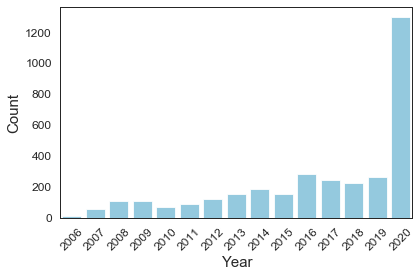

In [122]:
# year posted_on actions histogram

#plt.figure(figsize=(10,5))
b = sns.countplot(x="posted_on_year", data=df_alt_to_wiki, color="skyblue")
b.set_xticklabels(b.get_xticklabels(), rotation=45)
b.set_xlabel("Year",fontsize=15)
b.set_ylabel("Count",fontsize=15)
b.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig("figures/wiki_postedon_year.pdf")

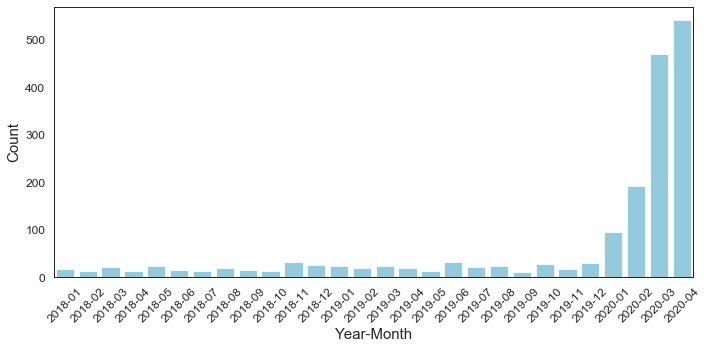

In [123]:
# month-year posted_on actions histogram

since_when = 2018
plt.figure(figsize=(10,5))
b = sns.countplot(x="posted_on_ym", data=df_alt_to_wiki[df_alt_to_wiki.posted_on_year>=since_when], order=sorted(df_alt_to_wiki[df_alt_to_wiki.posted_on_year>=since_when].posted_on_ym.unique()), color="skyblue")
b.set_xticklabels(b.get_xticklabels(), rotation=45)
b.set_xlabel("Year-Month",fontsize=15)
b.set_ylabel("Count",fontsize=15)
b.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig("figures/wiki_postedon_year_month.pdf")

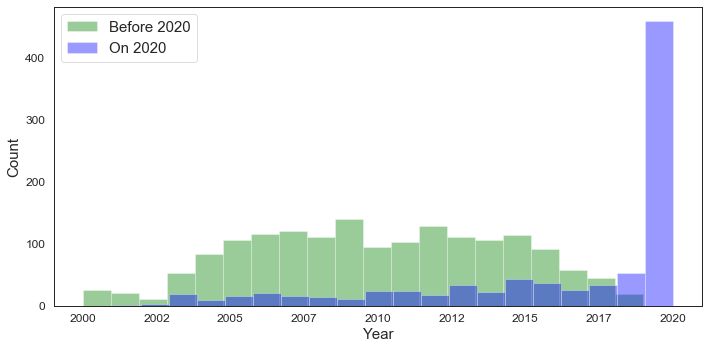

In [128]:
# publication years of articles cited by Wikipedia by posted_on action 
#(i.e., with duplicates for multiple posted_on actions on different Wikipedia pages)

since_when = 2020
from_when = 2000

df_alt_to_wiki_joined_altmetrics = df_alt_to_wiki.merge(df_altmetrics, how="left", left_on="altmetric_id", right_on="altmetric_id")
plt.figure(figsize=(10,5))
#sns.distplot([int(l) for l in df_alt_to_wiki_joined_altmetrics[(df_alt_to_wiki_joined_altmetrics.year>=from_when)].year.to_list()], bins=20, color="skyblue", kde=False, label="All")
sns.distplot([int(l) for l in df_alt_to_wiki_joined_altmetrics[(df_alt_to_wiki_joined_altmetrics.posted_on_year<since_when) & (df_alt_to_wiki_joined_altmetrics.year>=from_when)].year.to_list()], bins=20, color="green", kde=False, label="Before %d"%since_when)
b = sns.distplot([int(l) for l in df_alt_to_wiki_joined_altmetrics[(df_alt_to_wiki_joined_altmetrics.posted_on_year>=since_when) & (df_alt_to_wiki_joined_altmetrics.year>=from_when)].year.to_list()], bins=20, color="blue", kde=False, label="On %d"%since_when)
b.set_xlabel("Year",fontsize=15)
b.set_ylabel("Count",fontsize=15)
b.tick_params(labelsize=12)
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig("figures/wiki_year_postedon.pdf")

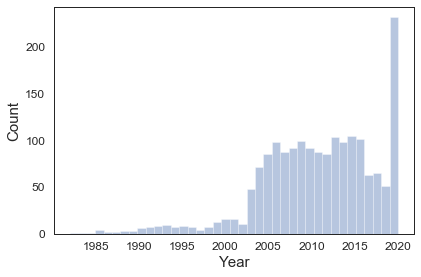

In [167]:
# publication years of articles cited by Wikipedia

#plt.figure(figsize=(10,5))
#sns.distplot(df_meta[df_meta.publication_year>1979].publication_year, color="skyblue", bins=39, label="All", norm_hist=False, kde=False)
b = sns.distplot(df_alt_to_wiki_joined_altmetrics[df_alt_to_wiki_joined_altmetrics.year>1979].groupby("altmetric_id").first().reset_index().year, bins=39, label="In Wikipedia", norm_hist=False, kde=False)
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
#b.set_xticklabels(b.get_xticklabels(), rotation=45)
b.set_xlabel("Year",fontsize=15)
b.set_ylabel("Count",fontsize=15)
b.tick_params(labelsize=12)
#plt.legend(fontsize=15)
plt.tight_layout()
#plt.savefig("figures/wiki_year_both.pdf")
plt.savefig("figures/wiki_year.pdf")

In [422]:
# Fraction of cited papers per year
coverage_by_year = list()
since_when = 2003
for y in range(since_when,2021):
    cov = df_alt_to_wiki_joined_altmetrics[df_alt_to_wiki_joined_altmetrics.year==y].shape[0]/df_meta[df_meta.publication_year==y].shape[0]
    coverage_by_year.append(cov)
    #print(y,cov)

In [417]:
df_joined_all[df_joined_all.in_wikipedia==True].shape[0]/df_meta.shape[0]

0.03108519487201475

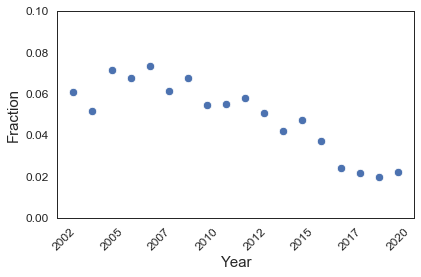

In [420]:
b = sns.scatterplot([y for y in range(since_when,2021)],coverage_by_year,s=70)
b.set_xlabel("Year",fontsize=15)
b.set_ylabel("Fraction",fontsize=15)
b.set_xticklabels(range(since_when,2021),rotation=45)
b.tick_params(labelsize=12)
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
plt.ylim((0,0.1))
plt.tight_layout()
plt.savefig("figures/wiki_fraction_year.pdf")

In [180]:
# most Wiki cited papers

In [181]:
df_top_cited = df_alt_to_wiki.groupby("doi").agg('count').sort_values('wikipedia_id',ascending=False)[:20]
df_top_cited.reset_index(inplace=True)

In [182]:
df_top_cited[["doi",'wikipedia_id']].merge(df_joined, how="left", right_on="doi", left_on="doi")[["doi",
    "wikipedia_id","title","publication_year","journal","times_cited"]]

,doi,wikipedia_id,title,publication_year,journal,times_cited
0,10.1007/s00705-012-1299-6,18,Ratification vote on taxonomic proposals to th...,2012.0,Arch Virol,207.0
1,10.3390/v2081803,15,Coronavirus Genomics and Bioinformatics Analysis,2010.0,Viruses,100.0
2,10.1007/978-1-4939-2438-7_1,13,Coronaviruses: An Overview of Their Replicatio...,2015.0,Methods in Molecular Biology,146.0
3,10.1016/s0140-6736(20)30183-5,12,Clinical features of patients infected with 20...,2020.0,The Lancet,1706.0
4,10.1056/nejmoa2001191,10,First Case of 2019 Novel Coronavirus in the Un...,2020.0,New England Journal of Medicine,417.0
5,10.1083/jcb.148.5.931,10,NaN,NaN,NaN,NaN
6,10.3390/v11020174,10,Global Epidemiology of Bat Coronaviruses,2019.0,Viruses,25.0
7,10.1128/jvi.06540-11,9,Discovery of Seven Novel Mammalian and Avian C...,2012.0,Journal of Virology,384.0
8,10.1038/d41586-020-00548-w,9,Mystery deepens over animal source of coronavirus,2020.0,Nature,4.0
9,10.1056/nejmoa2001316,9,"Early Transmission Dynamics in Wuhan, China, o...",2020.0,New England Journal of Medicine,935.0


In [435]:
#print(df_top_cited[["doi",'wikipedia_id']].merge(df_joined, how="left", right_on="doi", left_on="doi")[[
#    "wikipedia_id","doi","title","publication_year","journal","times_cited"]].to_latex(index=False,bold_rows=True,caption="",label=""))

In [183]:
# most citing Wiki articles

In [184]:
df_top_citing = df_alt_to_wiki.groupby("wikipedia_id").agg('count').sort_values('doi',ascending=False)[:20]
df_top_citing.reset_index(inplace=True)

In [185]:
df_top_citing[["altmetric_id",'wikipedia_id']].merge(df_wikipedia, how="left", right_on="wikipedia_id", left_on="wikipedia_id")[["altmetric_id",
    "wikipedia_id","title","page_url","lang","summary"]]

,altmetric_id,wikipedia_id,title,page_url,lang,summary
0,127,63030231,Coronavirus disease 2019,http://en.wikipedia.org/?curid=63030231,en,Coronavirus disease 2019 (COVID-19) is an infe...
1,54,62786585,Severe acute respiratory syndrome coronavirus 2,http://en.wikipedia.org/?curid=62786585,en,Severe acute respiratory syndrome coronavirus ...
2,49,201983,Coronavirus,http://en.wikipedia.org/?curid=201983,en,Coronaviruses are a group of related viruses t...
3,47,62750956,2019–20 Wuhan coronavirus outbreak,http://en.wikipedia.org/?curid=62750956,en,"A new coronavirus, designated 2019-nCoV, was i..."
4,40,63676463,2019–20 coronavirus pandemic/sandbox,http://en.wikipedia.org/?curid=63676463,en,The 2019–20 coronavirus pandemic is an ongoing...
5,31,211547,Severe acute respiratory syndrome-related coro...,http://en.wikipedia.org/?curid=211547,en,Severe acute respiratory syndrome-related coro...
6,27,63435931,COVID-19 drug development,http://en.wikipedia.org/?curid=63435931,en,COVID-19 drug development is the research proc...
7,27,39532251,Middle East respiratory syndrome,http://en.wikipedia.org/?curid=39532251,en,For PCR testing the WHO recommends obtaining s...
8,22,19572217,Influenza,http://en.wikipedia.org/?curid=19572217,en,"Influenza, commonly known as ""the flu"", is an ..."
9,21,4354646,Emergent virus,http://en.wikipedia.org/?curid=4354646,en,An emergent virus is a virus that either has n...


In [428]:
#print(df_top_citing[["altmetric_id",'wikipedia_id']].merge(df_wikipedia, how="left", right_on="wikipedia_id", left_on="wikipedia_id")[["altmetric_id",
#    "wikipedia_id","title","lang"]].to_latex(index=False,bold_rows=True))

## Scite

Load Scite data.

In [191]:
df_scite = pd.read_csv("../cord-19/datasets/scite-covid-source-tallies.csv")

In [192]:
df_scite.head()

,doi,total,supporting,contradicting,mentioning,unclassified
0,10.1001/archinte.168.22.2489,120,9,3,108,0
1,10.1001/jama.2010.675,188,31,7,150,0
2,10.1001/jama.2014.2116,9,0,0,9,0
3,10.1001/jama.2016.17324,121,6,6,109,0
4,10.1001/jama.2017.8708,6,1,0,5,0


In [193]:
df_scite.rename(columns={"total":"scite_total","supporting":"scite_supporting","contradicting":"scite_contradicting",
                        "mentioning":"scite_mentioning"}, inplace=True)
df_scite.drop(columns="unclassified", inplace=True)

In [228]:
len(df_scite.doi.unique())

27216

In [229]:
df_joined_t = df_joined.merge(df_scite, how='left', left_on="doi", right_on="doi", copy=False)

In [230]:
df_joined_t.shape

(64040, 30)

#### Finish merges and save

In [231]:
df_altmetrics.pmid = pd.to_numeric(df_altmetrics.pmid)

In [232]:
## join with Altmetrics

df_tmp_a = df_altmetrics[pd.isnull(df_altmetrics.doi)] 
df_tmp_j = df_joined_t[pd.isnull(df_joined_t.doi)] 
df_joined_all = df_joined_t[pd.notnull(df_joined_t.doi)].merge(df_altmetrics[pd.notnull(df_altmetrics.doi)], suffixes=('','_y'), how="left", left_on="doi", right_on="doi")
df_joined_all.drop(columns=['pmid_y', 'year_y', 'title_y'],inplace=True)

In [233]:
df_joined_tt = df_tmp_j.merge(df_tmp_a, how="left", suffixes=('','_y'), left_on="pmid", right_on="pmid")
df_joined_tt.drop(columns=["doi_y", 'year_y', 'title_y'],inplace=True)
df_joined_all = pd.concat([df_joined_all,df_joined_tt])
df_joined_all.drop_duplicates("pub_id",inplace=True)
df_joined_all.reset_index(inplace=True,drop=True)

In [234]:
df_joined_all.shape

(64040, 45)

In [235]:
df_joined_all.columns

Index(['pub_id', 'title', 'abstract', 'publication_year', 'publication_month',
       'journal', 'volume', 'issue', 'pages', 'doi', 'pmid', 'pmcid',
       'dimensions_id', 'timestamp', 'lang', 'id', 'altmetric_id', 'year',
       'month', 'publication_date', 'publication_type', 'issn', 'times_cited',
       'relative_citation_ratio', 'for_top', 'for_bottom', 'scite_total',
       'scite_supporting', 'scite_contradicting', 'scite_mentioning',
       'altmetric_id_y', 'counts_mendeley', 'counts_news', 'counts_blogs',
       'counts_facebook', 'counts_policy', 'counts_wikipedia',
       'counts_twitter_count', 'counts_twitter_unique', 'counts_total',
       'altmetric_score', 'member_of_the_public', 'researcher', 'practitioner',
       'science_communicator'],
      dtype='object')

In [236]:
df_joined_all.drop(columns=["dimensions_id","year","month","altmetric_id","timestamp"], inplace=True)
df_joined_all.rename(columns={"id":"dimensions_id","altmetric_id_y":"altmetric_id","counts_twitter_count":"counts_twitter"}, inplace=True)

In [237]:
df_joined_all[df_joined_all.pub_id==29534]

,pub_id,title,abstract,publication_year,publication_month,journal,volume,issue,pages,doi,...,counts_policy,counts_wikipedia,counts_twitter,counts_twitter_unique,counts_total,altmetric_score,member_of_the_public,researcher,practitioner,science_communicator
28798,29534,Immune Response in the Brain: Glial Response a...,Abstract Although the brain has been considere...,2008.0,12.0,NeuroImmune Biology,NaN,NaN,NaN,10.1016/s1567-7443(07)10014-4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [238]:
df_joined_all["in_wikipedia"] = df_joined_all["counts_wikipedia"]>0

In [242]:
df_joined_all.shape

(64040, 41)

In [256]:
df_posted_on_first = df_alt_to_wiki[["altmetric_id","posted_on_year"]].groupby("altmetric_id").agg(min).reset_index()

In [261]:
df_joined_all = df_joined_all.merge(df_posted_on_first, how="left", left_on="altmetric_id", right_on="altmetric_id")

In [262]:
# save to disk

df_joined_all.to_csv("data/df_joined_all.csv", compression="gzip", index=False)
df_meta.to_csv("data/df_meta.csv", compression="gzip", index=False)

### Analysis of time to be cited from publication

In [269]:
# average time from publication to citations

df_posted_on_first = df_alt_to_wiki[["altmetric_id","posted_on_year","posted_on_month"]].groupby("altmetric_id").agg(min).reset_index()

In [270]:
df_posted_on_first = df_posted_on_first.merge(df_joined_all, how="left", right_on="altmetric_id", left_on="altmetric_id")

In [271]:
df_posted_on_first["time_from_pub_to_wiki"] = ((df_posted_on_first["posted_on_year_x"]*12)+df_posted_on_first["posted_on_month"]) - ((df_posted_on_first["publication_year"]*12)+df_posted_on_first["publication_month"])

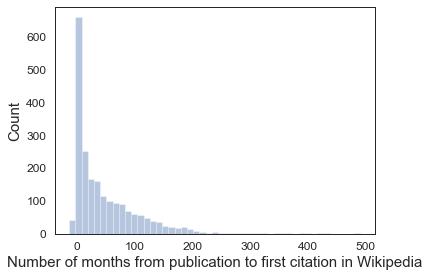

In [347]:
sns.distplot(df_posted_on_first["time_from_pub_to_wiki"], norm_hist=False, kde=False)
plt.xlabel("Number of months from publication to first citation in Wikipedia",fontsize=15)
plt.ylabel("Count",fontsize=15)
plt.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig("figures/nb1_time_from_pub_to_wiki_hist.pdf")

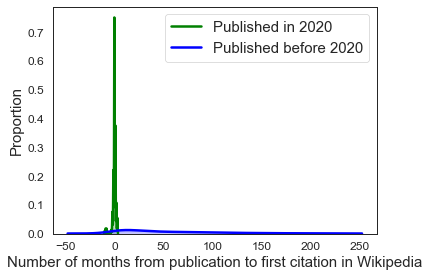

In [349]:
sns.distplot(df_posted_on_first[df_posted_on_first.publication_year==2020]["time_from_pub_to_wiki"], color="green", kde=True, norm_hist=True, kde_kws={"shade": True}, hist=False, label="Published in 2020")
sns.distplot(df_posted_on_first[(df_posted_on_first.publication_year<2020) & (df_posted_on_first.publication_year>1999)]["time_from_pub_to_wiki"], color="blue", kde=True, norm_hist=True, kde_kws={"shade": True}, hist=False, label="Published before 2020")
plt.legend(fontsize=15)
plt.xlabel("Number of months from publication to first citation in Wikipedia",fontsize=15)
plt.ylabel("Proportion",fontsize=15)
plt.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig("figures/nb1_time_from_pub_to_wiki_hist_normed.pdf")

In [340]:
#df_posted_on_first[["time_from_pub_to_wiki","posted_on_year_x","posted_on_month","publication_year","publication_month","in_wikipedia"]]

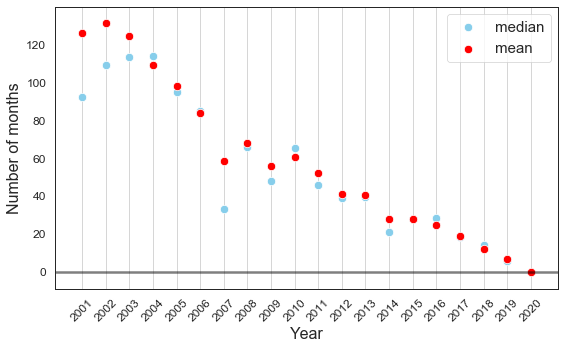

In [357]:
from_year = 2001
until_year = 2020
posted_on_limit = 2020

plt.figure(figsize=(8,5))
sns.scatterplot(x="publication_year", y="time_from_pub_to_wiki", data=df_posted_on_first[(df_posted_on_first.publication_year>=from_year)&(df_posted_on_first.publication_year<=until_year)&(df_posted_on_first.posted_on_year_x<=posted_on_limit)][["publication_year","time_from_pub_to_wiki"]].groupby("publication_year").agg(np.median).reset_index(), s=70, color="skyblue", label="median")
b = sns.scatterplot(x="publication_year", y="time_from_pub_to_wiki", data=df_posted_on_first[(df_posted_on_first.publication_year>=from_year)&(df_posted_on_first.publication_year<=until_year)&(df_posted_on_first.posted_on_year_x<=posted_on_limit)][["publication_year","time_from_pub_to_wiki"]].groupby("publication_year").agg(np.mean).reset_index(), s=70, color="red", label="mean")
b.set_xticklabels(b.get_xticklabels(), rotation=45)
plt.legend(fontsize=15)
plt.ylabel("Number of months",fontsize=16)
plt.xlabel("Year",fontsize=16)
plt.xticks(range(from_year,until_year+1))
plt.tick_params(labelsize=12)
plt.axhline(y=0.0, color='black', linestyle='-', alpha=0.5)
ax = plt.gca()
ax.grid(True, axis='x')
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
#plt.title("Number of months elapsed from publication to the first Wikipedia citation", fontsize=17)
plt.tight_layout()
plt.savefig("figures/nb1_time_from_pub_to_wiki_avg_per_year.pdf")

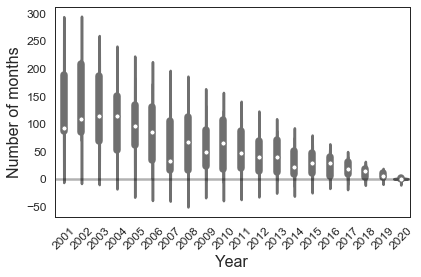

In [410]:
from_year = 2001
until_year = 2020
posted_on_limit = 2020

#fig, ax = plt.subplots(figsize=(8,5))
#fig, ax = plt.subplots()
#sns.scatterplot(x="publication_year", y="time_from_pub_to_wiki", data=df_posted_on_first[(df_posted_on_first.publication_year>=from_year)&(df_posted_on_first.publication_year<=until_year)&(df_posted_on_first.posted_on_year_x<=posted_on_limit)][["publication_year","time_from_pub_to_wiki"]].groupby("publication_year").agg(np.median).reset_index(), s=70, color="skyblue", label="median")
#sns.violinplot(x="day", y="total_bill", hue="sex",
#                    data=tips, palette="Set2", split=True,
#                    scale="count", inner="stick")
#a = sns.scatterplot(x="publication_year", y="time_from_pub_to_wiki", data=df_posted_on_first[(df_posted_on_first.publication_year>=from_year)&(df_posted_on_first.publication_year<=until_year)&(df_posted_on_first.posted_on_year_x<=posted_on_limit)][["publication_year","time_from_pub_to_wiki"]].groupby("publication_year").agg(np.mean).reset_index(), s=70, color="red", ax=ax)
#ax2 = ax.twinx()
#b = sns.catplot(x="publication_year", y="time_from_pub_to_wiki", data=df_posted_on_first[(df_posted_on_first.publication_year>=from_year)&(df_posted_on_first.publication_year<=until_year)&(df_posted_on_first.posted_on_year_x<=posted_on_limit)][["publication_year","time_from_pub_to_wiki"]], color="gray", s=3)
b = sns.violinplot(x="publication_year", y="time_from_pub_to_wiki", data=df_posted_on_first[(df_posted_on_first.publication_year>=from_year)&(df_posted_on_first.publication_year<=until_year)&(df_posted_on_first.posted_on_year_x<=posted_on_limit)][["publication_year","time_from_pub_to_wiki"]], color="skyblue", s=3)
b.set_xticklabels(range(from_year,until_year+1),rotation=45)
plt.ylabel("Number of months",fontsize=16)
plt.xlabel("Year",fontsize=16)
plt.tick_params(labelsize=12)
plt.axhline(y=0.0, color='black', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.savefig("figures/nb1_time_from_pub_to_wiki_avg_per_year_violin.pdf")

In [356]:
df_meta[df_meta.publication_year==2020].shape

(20841, 15)

In [287]:
df_posted_on_first[["publication_year","time_from_pub_to_wiki"]].groupby("publication_year").agg(np.mean).reset_index()

,publication_year,time_from_pub_to_wiki
0,1978.0,422.000000
1,1979.0,491.000000
2,1982.0,316.000000
3,1983.0,435.000000
4,1984.0,294.000000
5,1985.0,348.250000
6,1986.0,400.000000
7,1987.0,391.000000
8,1988.0,344.500000
9,1989.0,359.000000


In [344]:
df_posted_on_first[(df_posted_on_first.publication_year==2020)&(df_posted_on_first.time_from_pub_to_wiki < 0)]

,altmetric_id,posted_on_year_x,posted_on_month,pub_id,title,abstract,publication_year,publication_month,journal,volume,...,counts_twitter_unique,counts_total,altmetric_score,member_of_the_public,researcher,practitioner,science_communicator,in_wikipedia,posted_on_year_y,time_from_pub_to_wiki
1773,73837281,2020,3,31937.0,Comparative therapeutic efficacy of remdesivir...,Middle East respiratory syndrome coronavirus (...,2020.0,12.0,Nature Communications,11,...,299.0,446.0,707.578,198.0,69.0,23.0,9.0,True,2020.0,-9.0
1775,74005599,2020,1,36160.0,"Pneumonia of Unknown Etiology in Wuhan, China:...",There is currently an outbreak of pneumonia of...,2020.0,3.0,Journal of Travel Medicine,27,...,548.0,630.0,527.110,450.0,53.0,35.0,10.0,True,2020.0,-2.0
1776,74006487,2020,2,13374.0,Comparison of broad-spectrum antiviral activit...,"Rocaglates, a class of natural compounds isola...",2020.0,3.0,Antiviral Research,175,...,10.0,21.0,69.750,8.0,2.0,0.0,0.0,True,2020.0,-1.0
1788,74404530,2020,1,12.0,Coronavirus Infections—More Than Just the Comm...,In this Viewpoint Anthony Fauci and colleagues...,2020.0,2.0,JAMA,323,...,2041.0,2509.0,2446.420,1604.0,166.0,224.0,47.0,True,2020.0,-1.0
1795,74464078,2020,1,26893.0,Clinical features of patients infected with 20...,BACKGROUND: A recent cluster of pneumonia case...,2020.0,2.0,The Lancet,395,...,15450.0,20501.0,13792.882,14061.0,667.0,510.0,205.0,True,2020.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2178,78956460,2020,4,13382.0,The FDA-approved Drug Ivermectin inhibits the ...,Although several clinical trials are now under...,2020.0,6.0,Antiviral Research,178,...,15281.0,18652.0,12067.914,14240.0,533.0,412.0,96.0,True,2020.0,-2.0
2196,79284284,2020,4,49980.0,Surgery in COVID-19 patients: operational dire...,The current COVID-19 pandemic underlines the i...,2020.0,12.0,World Journal of Emergency Surgery,15,...,10.0,12.0,9.200,9.0,0.0,1.0,0.0,True,2020.0,-8.0
2197,79289651,2020,4,59069.0,Early Release - High Contagiousness and Rapid ...,Severe acute respiratory syndrome coronavirus ...,2020.0,7.0,Emerging Infectious Diseases,26,...,12381.0,14277.0,7883.980,11195.0,625.0,315.0,244.0,True,2020.0,-3.0
2240,79907898,2020,4,34595.0,Targeting potential drivers of COVID-19: Neutr...,Coronavirus disease 2019 (COVID-19) is a novel...,2020.0,6.0,Journal of Experimental Medicine,217,...,751.0,1065.0,882.162,611.0,100.0,26.0,14.0,True,2020.0,-2.0
